In [4]:
import pandas as pd
import numpy as np
import torch
# import tensorflow as tf

# Use torch gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda:0


In [5]:
# Get data
train_data = pd.read_csv('/kaggle/input/d/tanasaflorinpetrisor/nitro2024/train.csv')
test_data = pd.read_csv('/kaggle/input/d/tanasaflorinpetrisor/nitro2024/test.csv')

train_data['class'] = train_data['class'].replace(True, 1).replace(False, 0)

/tmp/ipykernel_34/657301383.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data['class'] = train_data['class'].replace(True, 1).replace(False, 0)


In [6]:
from transformers import AutoTokenizer, AutoModel
from torch import nn
from torch.optim import Adam
from tqdm.notebook import tqdm

In [7]:
tokenizer = AutoTokenizer.from_pretrained("Alegzandra/romanian_bert-finetuned-on-REDv2-romanian")
model = AutoModel.from_pretrained("Alegzandra/romanian_bert-finetuned-on-REDv2-romanian")


tokenizer_config.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/397k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [23]:
new_train_data = []
for i in range(len(train_data)):
    new_train_data.append((str(train_data['title'][i]) + " " + str(train_data["content"][i])).replace("\n", " "))
# for i in range(10):
#     print(new_train_data[i], end="\n\n")

In [8]:
import torch.nn.functional as F

config = {
    "max_sen_len": 512,
    'n_gram': 1,
    "batch_size": 4
}

class CNN(nn.Module):
    def __init__(self, alegzandra_finetuned_bert):
        super(CNN, self).__init__()
        self.alegzandra_finetuned_bert = alegzandra_finetuned_bert
        # 2 CNN layers and 1 linear layer for binary classification
        self.linear = nn.Linear(768, 2)
        self.cnn1 = nn.Conv1d(768, 256, 2)
        self.cnn2 = nn.Conv1d(256, 768, 2)
        self.relu = nn.ReLU()
        self.maxpool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.phrase_attention = Phrase_attention()
        self.self_attention = Self_Attention()
        
    def forward(self, p_input_ids, p_attention_mask):
        with torch.no_grad():
            x = self.alegzandra_finetuned_bert(input_ids=p_input_ids, attention_mask=p_attention_mask).last_hidden_state

        # x = x.unsqueeze(1)
        x = x.permute(0, 2, 1)
        # x = x.transpose(2, 1)
        
        # x = x.permute(1,0,2,3)
        
        # print(x.shape)
        
        # x is input [16, 512, 768] make it [768, 16, 512]
        # x = x.permute(2, 0, 1)
        
        # print('------')
#         print('Starting CNN')
        x = self.cnn1(x)
        # print(x.shape)
        x = self.relu(x)
        x = self.dropout(x)
        # print(x.shape)
        # print('=============')
        # print(x.shape)
        
        x = self.cnn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.maxpool(x).squeeze(2)

        # print(x.shape)
        # print('------')
        
        # x = x.transpose(0, 2)  
        s_a = []
        for i in range(len(x)):
            # print(i)
            text = x[i].unsqueeze(0).unsqueeze(0).permute(1, 2, 0)
            # print(text.shape)
            p_a = self.phrase_attention(text)
            # print('++++++++++')
            # print(p_a.shape)
            # print(text.shape)
            # print(p_a.unsqueeze(2).shape)
            
            s_a.append(self.self_attention(p_a * text).unsqueeze(2))
        
        # List of tensors to tensor
        s_a = torch.cat(s_a, dim=2).permute(2,0,1,3).to(device)
        # print(s_a.shape)
        
        x = self.maxpool(x)
        x = self.linear(s_a)
        # Exclude dimension 2
        x = x.view(x.size(0), -1)
        
        
        # print(x.shape)
        # x = x.squeeze(0)
        # x = x.transpose(0, 1)
        return x 
    
class Phrase_attention(nn.Module):
    def __init__(self):
        super(Phrase_attention, self).__init__()
        self.linear = nn.Linear(1, 768)
        self.tanh = nn.Tanh()
        self.u_w = nn.Parameter(nn.init.xavier_uniform_(torch.FloatTensor(768, 1)))

    def forward(self, embedding):
        # print("PA")
        # print(embedding.shape)
        u_t = self.tanh(self.linear(embedding))
        # u_t = u_t.transpose(0, 1)
        
        a = torch.matmul(u_t, self.u_w)
        # print('++++++++++')
        
        # print(a.shape)
        a = a.squeeze(2)
        # print('++++++++++')
        
        
        a = F.log_softmax(a, dim=1)
        
        return a

class Self_Attention(nn.Module):
    def __init__(self):
        super(Self_Attention, self).__init__()
        self.w1 = nn.Parameter(nn.init.xavier_uniform_(torch.FloatTensor(768, 1)))
        
        self.w2 = nn.Parameter(nn.init.xavier_uniform_(torch.FloatTensor(768, 1)))
        
        self.b = nn.Parameter(torch.FloatTensor(torch.randn(1)))

    def forward(self, embedding):
        f1 = torch.matmul(embedding, self.w1)

        # print('////////////////////')
        # print(f1.shape)        
        f2 = torch.matmul(embedding, self.w2)
        # print(f2.shape)
        
        f1 = f1.repeat(1, 1, embedding.size(1))
        # print(f1.shape)
        
        f2 = f2.repeat(1, 1, embedding.size(1))
        # print(f2.shape)
        

        f1 = f1
        S = f1 + f2 + self.b
        # S = S + self.b
        
        mask = torch.eye(768).type(torch.ByteTensor)
        # print('111')
        # print(S.shape)
        # print(S.shape)
        S = S.transpose(0,1)
        # print(embedding.shape)
        # print(S.shape)
        S = S.masked_fill(mask.bool().to(device), -float('inf'))
        # print('222')
        
        # print(S.shape)
        # print('333')
        max_row = F.max_pool1d(S, kernel_size=embedding.size(1), stride=1)
        # max_row.transpose(1, 2)
        # print(max_row.shape)
        a = F.softmax(max_row, dim=1).transpose(1, 2)
        # print(a.shape)
        embedding = embedding.squeeze(0)
        # print(embedding.shape)
        
        v_a = torch.matmul(a, embedding)

        return v_a
        

In [7]:
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
batch_size = 4

alegzandra_finetuned_bert = AutoModel.from_pretrained("Alegzandra/romanian_bert-finetuned-on-REDv2-romanian", output_hidden_states = True, num_labels=512).to(device)


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_data['class'])

model = CNN(alegzandra_finetuned_bert).to(device)

X_train, X_val, y_train, y_val = train_test_split(new_train_data, y, test_size=0.2, random_state=42)

loss_fn = nn.CrossEntropyLoss()
model.alegzandra_finetuned_bert.requires_grad_(False)
params = [param for param in model.parameters() if param.requires_grad]
optimizer = Adam(params, lr=0.0001)

losses = []
for epoch in range(1):
    for i in range(0, len(new_train_data), batch_size):
        model.train()
        model.alegzandra_finetuned_bert.eval()
        if i % 1000 == 0:
            print(i)
        X_train = tokenizer(new_train_data[i:i+batch_size], padding="max_length", truncation=True, return_tensors='pt', max_length=512)
        # print(X_train['input_ids'].shape)
        y_train = torch.tensor(y[i:i+batch_size], dtype=torch.int32).long().to(device)
        # print(X_train, y[i])

        p_input_ids = X_train['input_ids'].to(device)
        p_attention_mask = X_train['attention_mask'].to(device)

        # test = alegzandra_finetuned_bert(input_ids=p_input_ids, attention_mask=p_attention_mask).last_hidden_state
        # print(test.shape)

        res = model(p_input_ids, p_attention_mask)
        # res = torch.argmax(res).to(device)

        loss = loss_fn(res, y_train)
        if i % 1000 == 0:
            print(loss)
            torch.save(model.state_dict(), '/kaggle/working/model.pth')
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # break
        
        if i + batch_size > len(new_train_data):
            torch.save(model.state_dict(), '/kaggle/working/model.pth')
#             break


        # print(res[0].shape)
        # Validation
    model.eval()
    model.alegzandra_finetuned_bert.eval()
    with torch.no_grad():
        for i in range(0, len(X_val), batch_size):
            X_val_test = tokenizer(X_val[i:i+batch_size], padding="max_length", truncation=True, return_tensors='pt', max_length=512)
            y_val_test = torch.tensor(y_val[i:i+batch_size], dtype=torch.int32).long().to(device)

            p_input_ids = X_val_test['input_ids'].to(device)
            p_attention_mask = X_val_test['attention_mask'].to(device)

            res = model(p_input_ids, p_attention_mask)
            probabilities = torch.sigmoid(res)
            res = torch.argmax(probabilities, dim=-1).to(device)
            # if res < 0.5:
            #     res = 0
            # else:
            #     res = 1

            # # Balanced accuracy
            balanced_accuracy = balanced_accuracy_score(y_val_test.cpu(), res.cpu())
            
            if i % 500 == 0:
                print(balanced_accuracy)
            break
            
#             if i + batch_size > len(X_val):
#                 break
            
torch.save(model.state_dict(), '/kaggle/working/model.pth')


0
tensor(12.6981, device='cuda:0', grad_fn=<NllLossBackward0>)
1000
tensor(7.0765, device='cuda:0', grad_fn=<NllLossBackward0>)
2000
tensor(6.9895, device='cuda:0', grad_fn=<NllLossBackward0>)
3000
tensor(7.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
4000
tensor(6.8280, device='cuda:0', grad_fn=<NllLossBackward0>)
5000
tensor(6.6553, device='cuda:0', grad_fn=<NllLossBackward0>)
6000
tensor(6.8117, device='cuda:0', grad_fn=<NllLossBackward0>)
7000
tensor(6.8547, device='cuda:0', grad_fn=<NllLossBackward0>)
8000
tensor(6.8030, device='cuda:0', grad_fn=<NllLossBackward0>)
9000
tensor(7.3061, device='cuda:0', grad_fn=<NllLossBackward0>)
10000
tensor(6.6736, device='cuda:0', grad_fn=<NllLossBackward0>)
11000
tensor(6.6845, device='cuda:0', grad_fn=<NllLossBackward0>)
12000
tensor(6.7641, device='cuda:0', grad_fn=<NllLossBackward0>)
13000
tensor(6.8447, device='cuda:0', grad_fn=<NllLossBackward0>)
14000
tensor(6.8983, device='cuda:0', grad_fn=<NllLossBackward0>)
15000
tensor(6.7707, d

In [9]:
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
batch_size = 4

alegzandra_finetuned_bert = AutoModel.from_pretrained("Alegzandra/romanian_bert-finetuned-on-REDv2-romanian", output_hidden_states = True, num_labels=512).to(device)


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_data['class'])

model = CNN(alegzandra_finetuned_bert).to(device)
model.load_state_dict(torch.load('/kaggle/input/nitronlp/pytorch/aaaaaaaaaaa/1/model3.pth'))

loss_fn = nn.CrossEntropyLoss()
model.alegzandra_finetuned_bert.requires_grad_(False)
params = [param for param in model.parameters() if param.requires_grad]
optimizer = Adam(params, lr=0.0001)

In [26]:
from pandas import DataFrame

# Create data frame with id and class header
df = DataFrame(test_data['id'], columns=['id'])

new_test_data = []
for i in range(len(test_data)):
    new_test_data.append((str(test_data['title'][i]) + " " + str(test_data["content"][i])).replace("\n", " "))

with torch.no_grad():
    model.eval()
    for i in range(0, len(test_data), batch_size):
        X_test = tokenizer(new_test_data[i:i+batch_size], padding="max_length", truncation=True, return_tensors='pt', max_length=512)
        p_input_ids = X_test['input_ids'].to(device)
        p_attention_mask = X_test['attention_mask'].to(device)

        res = model(p_input_ids, p_attention_mask)
        probabilities = torch.sigmoid(res)
        res = torch.argmax(probabilities, dim=-1).to(device)
        
        # Add all rows from res to df
        for j in range(len(res)):
            df.loc[i+j, 'class'] = int(res[j].item())
        
        
        
df.to_csv('/kaggle/working/submission.csv', index=False)
        
        

KeyboardInterrupt: 

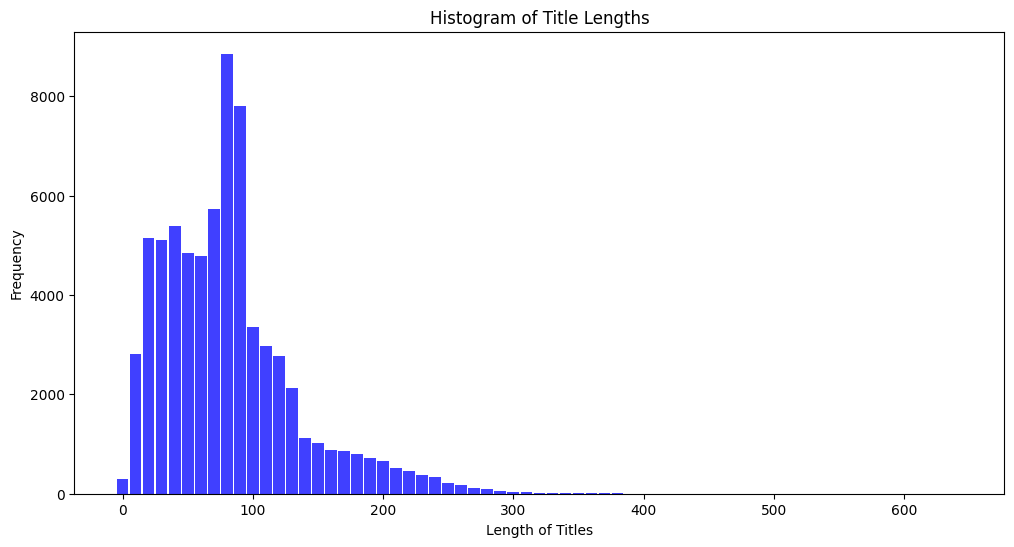

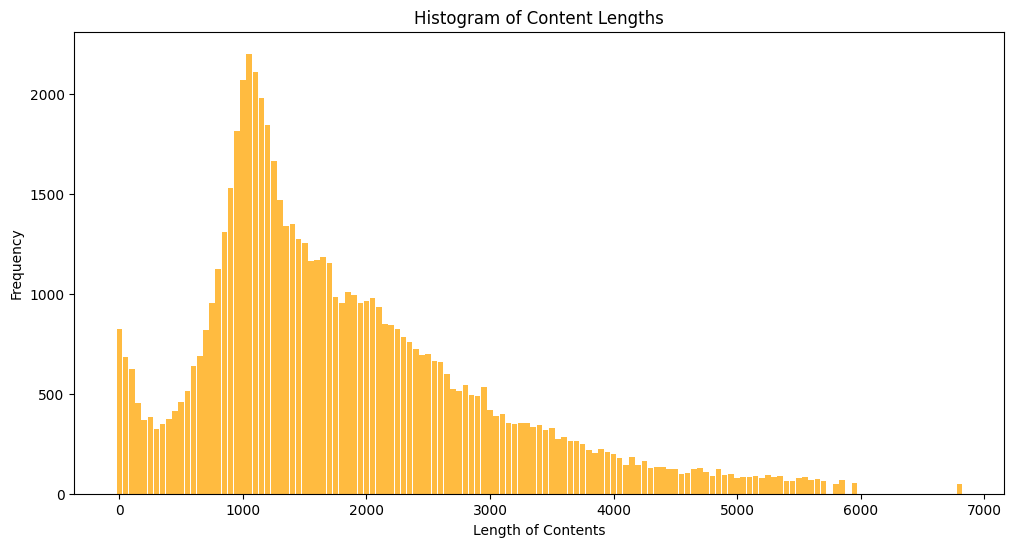

Title lengths frequency dictionary: {10: 2815, 80: 8854, 90: 7811, 30: 5112, 40: 5384, 70: 5721, 100: 3362, 160: 870, 170: 854, 250: 215, 20: 5147, 230: 378, 130: 2128, 60: 4774, 200: 658, 120: 2764, 50: 4841, 110: 2963, 0: 287, 210: 526, 220: 466, 150: 1019, 140: 1112, 240: 341, 180: 804, 270: 112, 260: 182, 190: 722, 320: 21, 310: 43, 340: 11, 290: 64, 350: 13, 280: 89, 300: 44, 420: 4, 330: 18, 360: 8, 560: 1, 370: 9, 380: 11, 410: 2, 400: 2, 450: 2, 440: 1, 540: 1, 470: 1, 390: 3, 430: 2, 580: 1, 640: 1}
Filtered content lengths frequency dictionary: {1500: 1254, 1350: 1341, 1300: 1471, 4000: 199, 600: 639, 3000: 419, 1600: 1172, 1800: 953, 3150: 355, 1650: 1185, 1000: 2072, 1100: 2111, 3200: 350, 200: 368, 3250: 354, 2750: 514, 850: 1312, 650: 690, 2550: 663, 1550: 1165, 2500: 698, 2100: 934, 950: 1813, 2200: 843, 3950: 208, 900: 1531, 750: 955, 3700: 264, 450: 412, 50: 682, 4550: 101, 2000: 962, 1250: 1666, 2300: 784, 1450: 1276, 2150: 849, 1150: 1978, 1850: 1011, 1950: 955, 2900

In [10]:
import matplotlib.pyplot as plt

lengths_title = {}
bin_title = 10

lengths_content = {}
bin_content = 50

for i in range(len(train_data)):
    try:
        if len(train_data['title'][i]) - len(train_data['title'][i]) % bin_title not in lengths_title.keys():
            lengths_title[len(train_data['title'][i]) - len(train_data['title'][i]) % bin_title] = 0
        lengths_title[len(train_data['title'][i]) - len(train_data['title'][i]) % bin_title] += 1
        
        if len(train_data['content'][i]) - len(train_data['content'][i]) % bin_content not in lengths_content.keys():
            lengths_content[len(train_data['content'][i]) - len(train_data['content'][i]) % bin_content] = 0
        lengths_content[len(train_data['content'][i]) - len(train_data['content'][i]) % bin_content] += 1
    except:
        continue
# Filter content bins to only include those with at least 50 counts
filtered_lengths_content = {k: v for k, v in lengths_content.items() if v >= 50}

# Convert dictionaries to lists for plotting
title_bins = list(lengths_title.keys())
title_counts = list(lengths_title.values())

content_bins = list(filtered_lengths_content.keys())
content_counts = list(filtered_lengths_content.values())

# Plotting the histogram for lengths of titles
plt.figure(figsize=(12, 6))
plt.bar(title_bins, title_counts, width=bin_title * 0.9, color='blue', alpha=0.75)  # Width is 90% of bin size for whitespace
plt.xlabel('Length of Titles')
plt.ylabel('Frequency')
plt.title('Histogram of Title Lengths')
plt.show()

# Plotting the histogram for lengths of contents
plt.figure(figsize=(12, 6))
plt.bar(content_bins, content_counts, width=bin_content * 0.9, color='orange', alpha=0.75)  # Width is 90% of bin size for whitespace
plt.xlabel('Length of Contents')
plt.ylabel('Frequency')
plt.title('Histogram of Content Lengths')
plt.show()

# Print the dictionaries (optional)
print("Title lengths frequency dictionary:", lengths_title)
print("Filtered content lengths frequency dictionary:", filtered_lengths_content)

In [52]:
from pandas import DataFrame
import pandas as pd
# Create data frame with id and class header
test_data = pd.read_csv('/kaggle/input/test-saroco/test.csv')
#df = DataFrame(test_data['id'], columns=['id'])
batch_size = 1

new_test_data = []
predicted_labels_dict= {}
true_labels_dict = {}
predicted_labels = []
predicted_labels_prob=[]
for i in range(len(test_data)):
    new_test_data.append((str(test_data['title'][i]) + " " + str(test_data["content"][i])).replace("\n", " "))

with torch.no_grad():
    model.eval()
    for i in range(0, len(test_data), batch_size):
        X_test = tokenizer(new_test_data[i:i+batch_size], padding="max_length", truncation=True, return_tensors='pt', max_length=512)
        p_input_ids = X_test['input_ids'].to(device)
        p_attention_mask = X_test['attention_mask'].to(device)

        res = model(p_input_ids, p_attention_mask)
        probabilities = torch.sigmoid(res)
        res = torch.argmax(probabilities, dim=-1).to(device)
        
        try:
        
            if len(test_data["content"][i]) - len(test_data["content"][i]) % 50 not in predicted_labels_dict.keys():
                predicted_labels_dict[len(test_data["content"][i]) - len(test_data["content"][i]) % 50] = []
                true_labels_dict[len(test_data["content"][i]) - len(test_data["content"][i]) % 50] = []

            predicted_labels_dict[len(test_data["content"][i]) - len(test_data["content"][i]) % 50].append(res[0].item())
            true_labels_dict[len(test_data["content"][i]) - len(test_data["content"][i]) % 50].append(test_data["label"][i])
            
            predicted_labels_prob.append(probabilities)
            predicted_labels.append(res[0].item())
        except:
            continue
        
        if i % 200 == 0:
            print(i)
        
        
        # Add all rows from res to df
#         for j in range(len(res)):
#             df.loc[i+j, 'class'] = int(res[j].item())
        
        
        
#df.to_csv('/kaggle/working/submission.csv', index=False)
        
        

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800


In [40]:
print(probabilities)
probabilities.size()

tensor([[0.6368, 0.4504, 0.6368,  ..., 0.4504, 0.6368, 0.4504]],
       device='cuda:0')


torch.Size([1, 1536])

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics

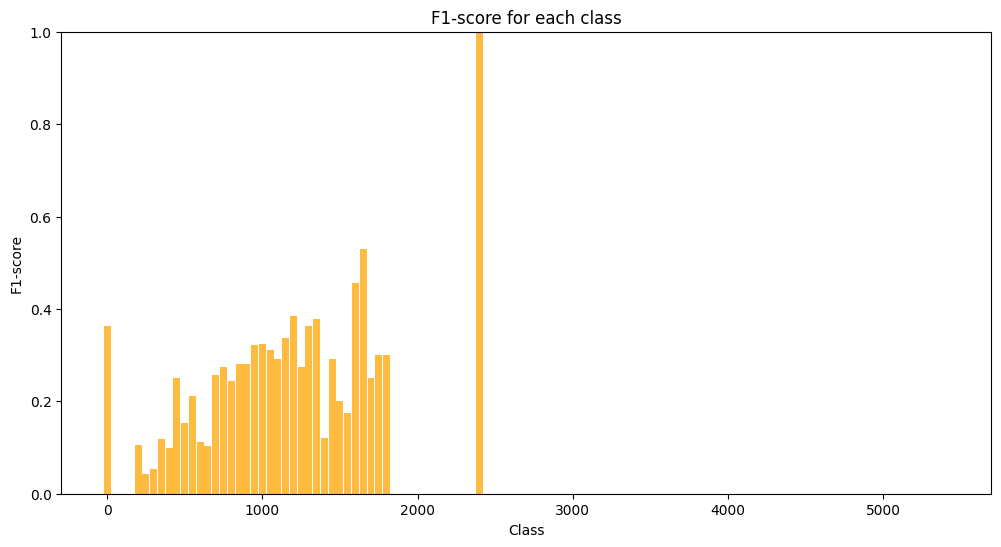

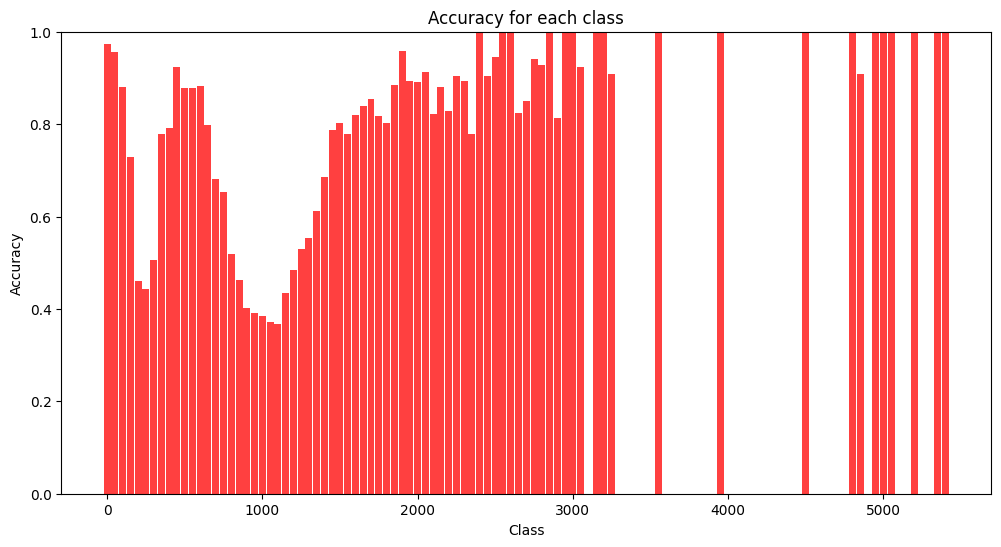

F1 score:  0.2959943282523928
Accuracy:  0.5944869831546707


In [61]:
from sklearn.metrics import f1_score, accuracy_score, average_precision_score, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

f1_bins = {}
accuracy_bins = {}

for i in predicted_labels_dict.keys():
    
    if len(predicted_labels_dict[i]) < 10:
        continue
    # Compute F1-score
    f1 = f1_score(true_labels_dict[i], predicted_labels_dict[i])

    # Compute accuracy
    accuracy = accuracy_score(true_labels_dict[i], predicted_labels_dict[i])

    f1_bins[i] = f1
    accuracy_bins[i] = accuracy

#     print("F1-score:", f1)
#     print("Accuracy:", accuracy)
    
# Extract keys and values for plotting
classes = list(f1_bins.keys())
f1_values = list(f1_bins.values())
accuracy_values = list(accuracy_bins.values())

# Plot F1-scores
plt.figure(figsize=(12, 6))
plt.bar(f1_bins.keys(), f1_bins.values(), width=50 * 0.9, color='orange', alpha=0.75)
plt.xlabel('Class')
plt.ylabel('F1-score')
plt.title('F1-score for each class')
plt.ylim(0, 1)  # Set y-axis limits for better comparison
plt.show()

# Plot Accuracies
plt.figure(figsize=(12, 6))
plt.bar(classes, accuracy_bins.values(), width=50 * 0.9, color='red', alpha=0.75)  # Width set to 50% for better spacing
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Accuracy for each class')
plt.ylim(0, 1)  # Set y-axis limits for better comparison
plt.show()

labeluri_nestricate = []
for i in range(len(test_data["content"])):
    try:
        if len(test_data["content"][i]) > 0:
            labeluri_nestricate.append(test_data["label"][i])
    except:
        continue
            
            
f1 = f1_score(labeluri_nestricate, predicted_labels)

accuracy = accuracy_score(labeluri_nestricate, predicted_labels)

print("F1 score: ", f1)
print("Accuracy: ", accuracy)

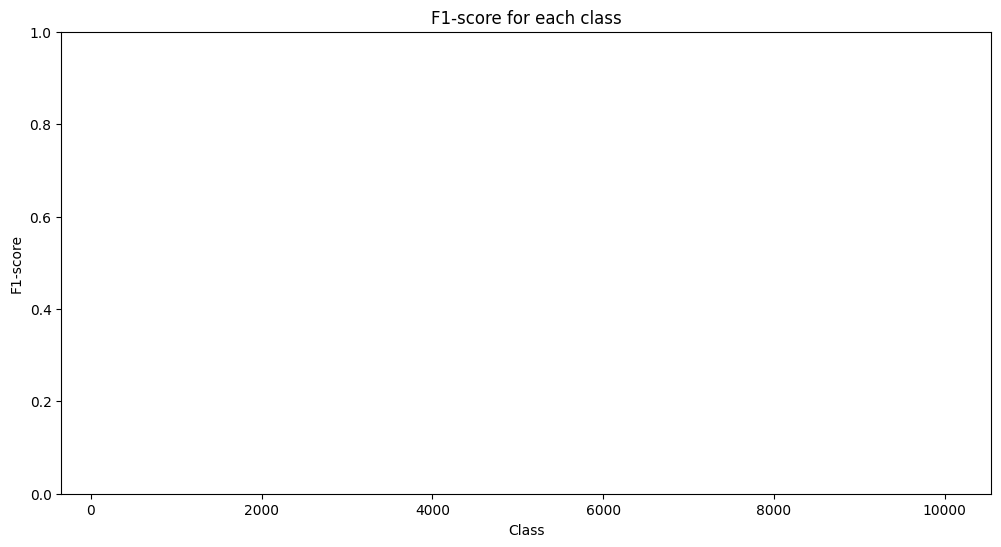

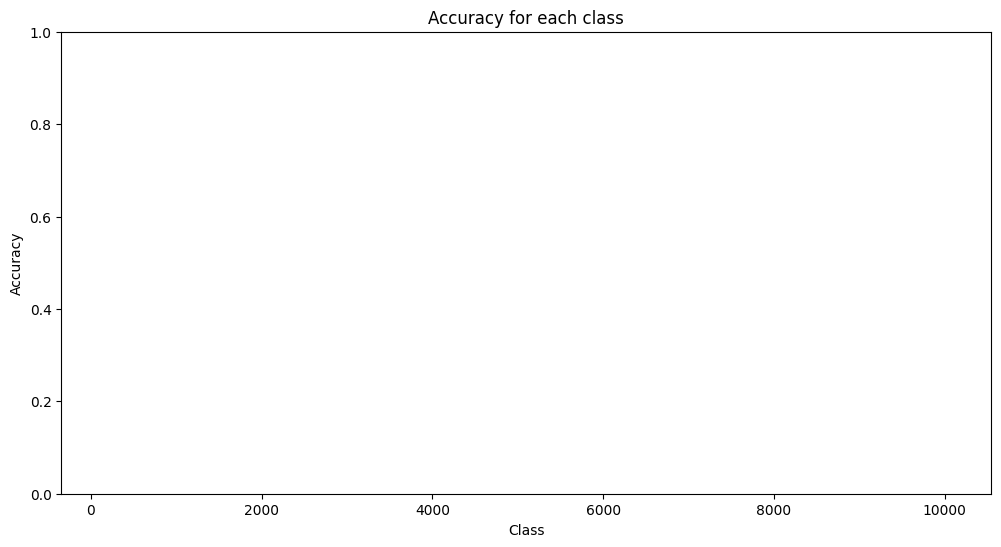

In [45]:
# Extract keys and values for plotting
classes = list(f1_bins.keys())
f1_values = list(f1_bins.values())
accuracy_values = list(accuracy_bins.values())

# Plot F1-scores
plt.figure(figsize=(12, 6))
plt.bar(classes, f1_values, width=0.5, color='skyblue', alpha=0.75)  # Width set to 50% for better spacing
plt.xlabel('Class')
plt.ylabel('F1-score')
plt.title('F1-score for each class')
plt.ylim(0, 1)  # Set y-axis limits for better comparison
plt.show()

# Plot Accuracies
plt.figure(figsize=(12, 6))
plt.bar(classes, accuracy_values, width=0.5, color='lightgreen', alpha=0.75)  # Width set to 50% for better spacing
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Accuracy for each class')
plt.ylim(0, 1)  # Set y-axis limits for better comparison
plt.show()